# Using Heuristics and Dynamic Programming to Solve the Class Scheduling Problem

In [230]:
import numpy as np
import random
import math
from functools import cmp_to_key

from course import *
from params import *
import matplotlib.pyplot as plt

In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, generate a toy data set

Greedy algorithM:
- schedule the class with the most demand first
- scheudle all the students and classes first, then assign the teachers.

Two ways to think about cost/optimal next choice:
- the class with the most studnets signed up for it (do this until every block fo the school day is full)
- the class with the least amount of students that would have a conflict with an existing, scheduled class
    - do this when choosing which class to place in a slot already occupied by another class to avoid conflicts as much as possible

Parameters:
 - N = 50 students, 2 grades
 - Each student takes six classes
 - N_t = 12 teachers. 2 teachers per subject

| Required Classes | Elective Classes |
|------------------|------------------|
| English          | Art              |
| Math             | History          |
| Science          | Computer Science |
| Language         |                  |

 - A school day consists of 7 blocks
 
| Block |
|-------|
|   A   |
|   B   |
|   C   |
|   D   |
|   E   |
|   F   |
|   G   |

## Initial Parameters

Get from params.py

## Generate Mock Data

In [232]:
english_courses = [
    Course("ENG10"),
    Course("ENG20"),]

math_courses = [
    Course("MATH10"),
    Course("MATH20"),]

science_courses = [
    Course("SCI10"),
    Course("SCI20"),]

history_courses = [
    Course("HIST10"),
    Course("HIST20"),]

language_courses = [
    Course("SPA10"),
    Course("SPA20"),]

art_courses = [
    Course("ART10"),
    Course("ART20"),]

computer_courses = [
    Course("COM10"),
    Course("COM20"),]

# Create a list of all courses
all_courses = [english_courses, math_courses, science_courses, history_courses, art_courses, computer_courses, language_courses]
all_courses_flattened = english_courses + math_courses + science_courses + history_courses + art_courses + computer_courses + language_courses

Now for the students

In [233]:
students = []

# Create 100 students with random course selections
for i in range(N_STUDENTS):
    eng = random.choice(english_courses)
    mat = random.choice(math_courses)
    sci = random.choice(science_courses)
    lan = random.choice(language_courses)    

    elective_courses = [art_courses, computer_courses, history_courses]

    sub1, sub2 = random.sample(elective_courses, 2) # Select 2 random elective courses
    elective1 = random.choice(sub1)
    elective2 = random.choice(sub2)
    student = Student(f"Student {i+1}", [eng, mat, sci, lan], [elective1, elective2])
    students.append(student)

In [234]:
len(all_courses_flattened[0].students)

47

Now for the teachers

In [235]:
teachers = []

# Create 14 teachers with 2 per subject

for i in range(N_TEACHERS):
    subject_courses = all_courses[i//2] # mod shouldn't be needed since there are 7 subjects and 14 teachers
    print(subject_courses)

    preferred, neutral = random.sample(subject_courses, 2) # Select 2 random courses from the subject
    teacher = Teacher(f"Teacher {i+1}", preferred_courses=[preferred], neutral_courses=[neutral])
    teachers.append(teacher)


[ENG10, ENG20]
[ENG10, ENG20]
[MATH10, MATH20]
[MATH10, MATH20]
[SCI10, SCI20]
[SCI10, SCI20]
[HIST10, HIST20]
[HIST10, HIST20]
[ART10, ART20]
[ART10, ART20]
[COM10, COM20]
[COM10, COM20]
[SPA10, SPA20]
[SPA10, SPA20]


Plot the data

In [236]:
course_frequencies = {course.name: 0 for course in all_courses_flattened}
for student in students:
    courses = student.get_all_courses()
    for course in courses:
        course_frequencies[course.name] += 1
print(course_frequencies)

{'ENG10': 47, 'ENG20': 53, 'MATH10': 54, 'MATH20': 46, 'SCI10': 56, 'SCI20': 44, 'HIST10': 35, 'HIST20': 41, 'ART10': 33, 'ART20': 29, 'COM10': 32, 'COM20': 30, 'SPA10': 51, 'SPA20': 49}


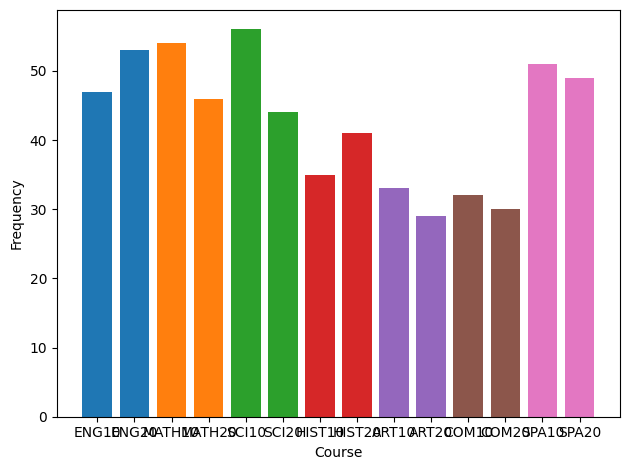

In [237]:
# create a histogram of the course frequencies for each subject
for i in range(0, len(all_courses_flattened), 2):
    plt.plot(4, 2, i+1)
    plt.bar([all_courses_flattened[i].name, all_courses_flattened[i+1].name], [course_frequencies[all_courses_flattened[i].name], course_frequencies[all_courses_flattened[i+1].name]])
    plt.xlabel('Course')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Zoomed in plot of just English

<BarContainer object of 2 artists>

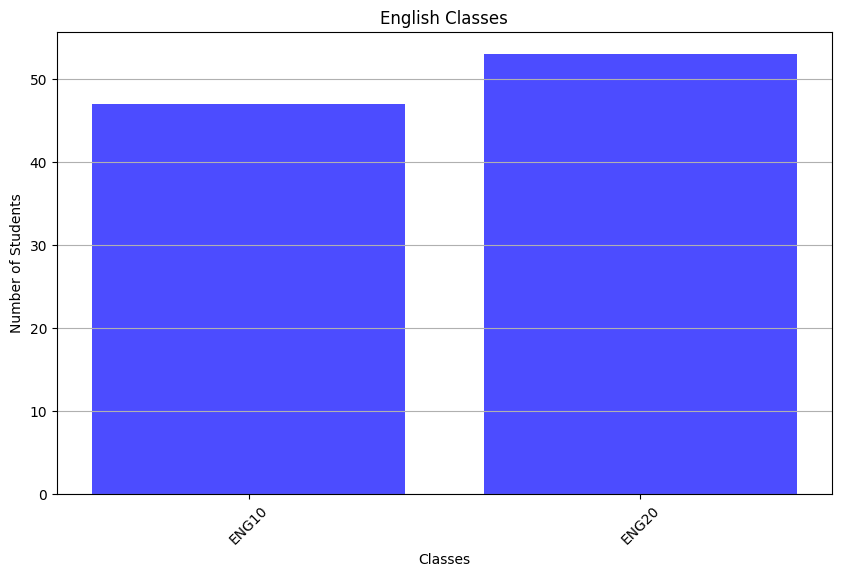

In [238]:
# plot the frequencies of each class for each subject
# english:
plt.figure(figsize=(10, 6))
plt.title("English Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Students")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.bar([english_courses[0].name, english_courses[1].name], [course_frequencies[english_courses[0].name], course_frequencies[english_courses[1].name]], color='blue', alpha=0.7)

### Step 1: Determining the Number of Sections to Create

Starting with English, we rank the courses based on desirability. Then we create a section for each of them. Keep track of the saturation of blocks, assigning sections to the least saturated block.

In [239]:
block_counts: dict[int, int] = {i: 0 for i in range(0, 7)}

def assign_block_and_teachers(courses: list[Course]):
    """Assigns blocks and teachers to the courses in the given list.
    
    Args:
        courses (list[Course]): List of Course objects.
    """
    sorted_courses = sorted(courses, key=lambda x: x.get_course_desirability_teaching(), reverse=True)
    for course in sorted_courses:
        num_sections = math.ceil(course_frequencies[course.name] / IDEAL_CLASS_SIZE)
    
        for i in range(num_sections):
            teacher = course.get_best_teacher()
            if not teacher:
                print(f"No more available teachers for {course.name}")
                break
            sorted_blocks = sorted(block_counts.items(), key=lambda x: x[1])

            # find the best free block for the teacher
            j = 0
            best_block = sorted_blocks[j][0]
            while best_block in teacher.teaching_blocks:
                j = (j + 1) % len(sorted_blocks)
                best_block = sorted_blocks[j][0]
            print(f"Assigning {course.name} to block {best_block} with teacher {teacher.name}")
            course.create_section(teacher=teacher, block=best_block) # creating without students
            block_counts[best_block] += 1

for subject_courses in all_courses:
    assign_block_and_teachers(subject_courses)

Assigning ENG10 to block 0 with teacher Teacher 2
Assigning ENG10 to block 1 with teacher Teacher 2
Assigning ENG10 to block 2 with teacher Teacher 2
Assigning ENG10 to block 3 with teacher Teacher 2
Assigning ENG20 to block 4 with teacher Teacher 1
Assigning ENG20 to block 5 with teacher Teacher 1
Assigning ENG20 to block 6 with teacher Teacher 1
Assigning ENG20 to block 0 with teacher Teacher 1
No more available teachers for ENG20
Assigning MATH10 to block 1 with teacher Teacher 4
Assigning MATH10 to block 2 with teacher Teacher 4
Assigning MATH10 to block 3 with teacher Teacher 4
Assigning MATH10 to block 4 with teacher Teacher 4
Assigning MATH10 to block 5 with teacher Teacher 3
Assigning MATH20 to block 6 with teacher Teacher 3
Assigning MATH20 to block 0 with teacher Teacher 3
Assigning MATH20 to block 1 with teacher Teacher 3
No more available teachers for MATH20
Assigning SCI10 to block 2 with teacher Teacher 5
Assigning SCI10 to block 3 with teacher Teacher 5
Assigning SCI10 t

Let's see how we're doing

In [240]:
for course in all_courses_flattened:
    print(course.sections)

[ENG10, block 0, ENG10, block 1, ENG10, block 2, ENG10, block 3]
[ENG20, block 4, ENG20, block 5, ENG20, block 6, ENG20, block 0]
[MATH10, block 1, MATH10, block 2, MATH10, block 3, MATH10, block 4, MATH10, block 5]
[MATH20, block 6, MATH20, block 0, MATH20, block 1]
[SCI10, block 2, SCI10, block 3, SCI10, block 4, SCI10, block 5, SCI10, block 6]
[SCI20, block 0, SCI20, block 1, SCI20, block 2]
[HIST10, block 3, HIST10, block 4, HIST10, block 5]
[HIST20, block 6, HIST20, block 0, HIST20, block 1, HIST20, block 2]
[ART10, block 6, ART10, block 0, ART10, block 1]
[ART20, block 3, ART20, block 4, ART20, block 5]
[COM10, block 2, COM10, block 3, COM10, block 4]
[COM20, block 5, COM20, block 6, COM20, block 0]
[SPA10, block 1, SPA10, block 2, SPA10, block 3, SPA10, block 4]
[SPA20, block 5, SPA20, block 6, SPA20, block 0, SPA20, block 1]


### Assigning students to courses

Start with the course with the least # of sections.

Then, iterate over the sections, and for each student in that course:
- assign the students based on their scheudles, which has two parts.
 - Assign students with the least other classes also taught in this block (minimize conflict of schedules). If there is overlap, assign the students with the most # of available sections combined between their other courses (in theory, they are the most flexible)

In [241]:

sorted_courses = sorted(all_courses_flattened, key=lambda x: len(x.sections))
print("Sorted courses by least amount of sections:")
for course in sorted_courses:
    students_remaining = course.students.copy()
    print(course.name, len(course.sections))

    ideal_students_per_section = math.ceil(len(course.students)/len(course.sections))
    print("Ideal students per section:", ideal_students_per_section)
    for section in course.sections:

        # first, sort the students based on the ones we should assign first (algorithm described above)
        def compare_students(s1: Student, s2: Student):
            s1_block_overlap = 0
            for course in s1.get_all_courses():
                for section in course.sections:
                    if section.block == section.block:
                        s1_block_overlap += 1

            s2_block_overlap = 0
            for course in s2.get_all_courses():
                for section in course.sections:
                    if section.block == section.block:
                        s2_block_overlap += 1
            
            if s1_block_overlap != s2_block_overlap:
                return s1_block_overlap - s2_block_overlap # if s1 has more overlap, it is less desirable to place in this block

            else:
                return s1.get_flexibility() - s2.get_flexibility() # students with less flexibility are more desirable to place in this block

        students_remaining = sorted(students, key=cmp_to_key(compare_students))
        
        # next, decide on how many of the students to assign to this section. Try for even split between all sections?


Sorted courses by least amount of sections:
MATH20 3
Ideal students per section: 16
SCI20 3
Ideal students per section: 15
HIST10 3
Ideal students per section: 12
ART10 3
Ideal students per section: 11
ART20 3
Ideal students per section: 10
COM10 3
Ideal students per section: 11
COM20 3
Ideal students per section: 10
ENG10 4
Ideal students per section: 12
ENG20 4
Ideal students per section: 14
HIST20 4
Ideal students per section: 11
SPA10 4
Ideal students per section: 13
SPA20 4
Ideal students per section: 13
MATH10 5
Ideal students per section: 11
SCI10 5
Ideal students per section: 12


Start with 1 subject. Then:

1. Assign the number of classes based on demand.

$n = \lceil \frac{\text{num students}}{\text{optimal class size}} \rceil$

2. Fix the classes within the school day.

3. Put students in classes based on student schedule

### Heuristic for assigning teachers to courses to maximize satisfaction:
Repeat:

2 rounds of scheduling all teachers who prefer teaching the course

1 round of teachers who are neutral to it

####  Assigning teachers to courses 
For teachers who both prefer teaching the same course.

- Assing a "pickiness" score to each teacher. +1 for P and U, +0 for neutral.

- Assign a "Desirability" rating for each class. +2 for P, +1 for N, +0 for U.

Start with the least desirable course. If there's a tie for preference between teachers, break the tie by assigning the pickiest teacher to that course first. Update the pickiness rating of each teacher as each class is assigned.

Notes:
- If a teacher dislikes teaching a course, avoid it if at all possible.


#### Assigning students to courses

- Start with the student with the least amount of flexibility. Flexibility is defined as:
    - ex. flexibility for english: 
    calculate the number of overlapping blocks with their math section, then history, then language. Sum these up

Popularity of a class = number of students registered / number of sections.



### Assigning courses to sections
Note: Create a class for Block, keeping track of all the sections corresponding to that block. That's an easy way to track oversaturated versus undersaturated blocks. Assign courses based on the least saturated block.

In [66]:
# sort the classes by frequency
sorted_courses = sorted(english_courses, key=lambda x: course_frequencies[x.name], reverse=True)
for course in sorted_courses:
    class_name = course.name
    plt.bar(class_name, course_frequencies[class_name], color='blue', alpha=0.7)


for course in sorted_courses:
    num_sections = math.ceil(course_frequencies[course.name] / IDEAL_CLASS_SIZE)
    print(f"{course}: {num_sections} sections. Teachers: {course.teachers}")

    num_sections_assigned = 0

    while num_sections_assigned < num_sections:
        # Assign teachers to sections
        for teacher in course.preferred_teachers: 
            
    for i in range(num_sections):
        course.create_section(block=i)
    


IndentationError: expected an indented block after 'for' statement on line 16 (1854192265.py, line 18)

Constraint: each teacher teaches at most 4 sections

Evaluating a position:
- cost-to-go. Come up with a way to evaluate a position based on the features of it. (how constrained it is)

Compare all permutations of courses in which blocks.


What is the algorithm for assigning students?
- take all of the students that have that block free. Pick a random sample of them to fill it up. Since elective sare placed last, this should prioritize filling the required courses.

## 3 possible methods to consider

### 1. student first (prioritize student elective satisfaction)
Go through each student, place each class based on their schedule. If a class already exists (and the capacity is less than maxium amount), assign the student to that class, otherwise open a new section.

### 2. teacher first (prioritize number of blocks that teachers will teach)
Assign teacher schedules based on their desired teaching schedule. (i.e. 4 sections even w/50 students because teachers prefer only 4)

### 3. class sizes (prioritize size of each class)
Assign the total number of sections for each course first. (i.e. 5 sections b/c 50 students)

***********

Methods 2 and 3 are similar because you assign the teacher schedules first, then place the students.